# 1. Limit Vram

In [1]:
import tensorflow as tf
import os

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

/Users/taehmotheus/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.14.0


# 3. Load Data

Found 57858 files belonging to 2 classes.


2023-12-03 13:06:25.450624: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-03 13:06:25.450659: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-03 13:06:25.450667: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-03 13:06:25.450885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-03 13:06:25.451092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


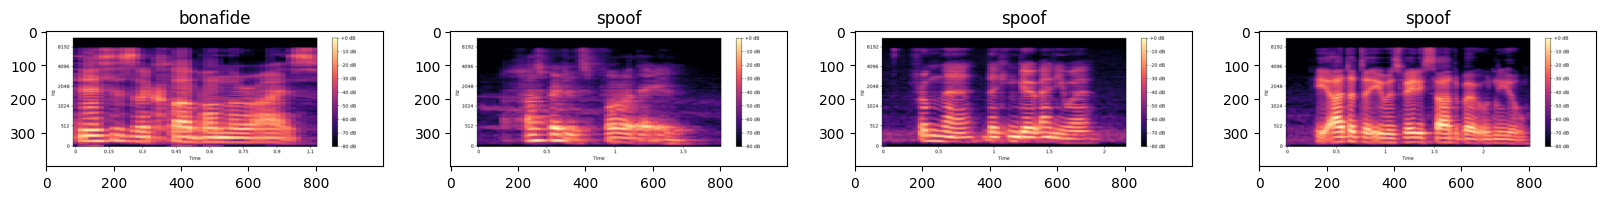

In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

# Load the dataset
data = tf.keras.utils.image_dataset_from_directory(
    'data/processed',  # Adjust this path to where your image data is stored
    labels='inferred',
    label_mode='int',
    image_size=(400, 1000),
    batch_size=32
)

# Get class names
class_names = data.class_names

# Create an iterator to retrieve batches
data_iterator = data.as_numpy_iterator()

# Retrieve the first batch of images
batch = data_iterator.next()

# Setup Matplotlib figure and axes
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Display the first four images in the batch
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(np.uint8))  # Convert to uint8 for proper display
    label_index = batch[1][idx]
    ax[idx].title.set_text(class_names[label_index])

plt.show()  # Show the plot


# 4. Scale Data

In [5]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         ...,
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],
 
 
        [

# 5. Split Data

In [6]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [7]:
train_size

1266

# 6. Build Deep Learning Model

# 7. Train

In [12]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
with tf.device("/gpu:0"):
    hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])

  53/1266 [>.............................] - ETA: 3:04:55 - loss: 1.0636 - accuracy: 0.6327

KeyboardInterrupt: 

# 8. Plot Performance

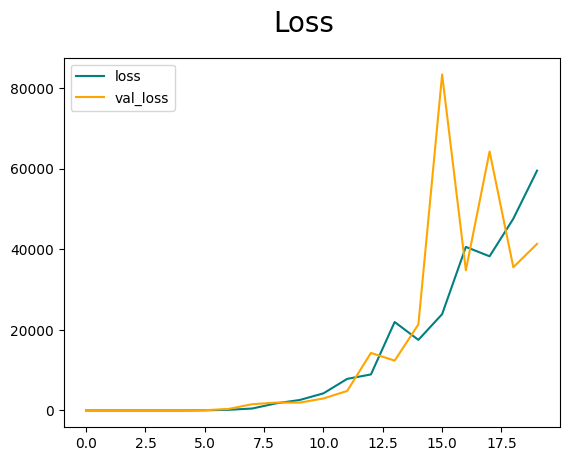

In [12]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

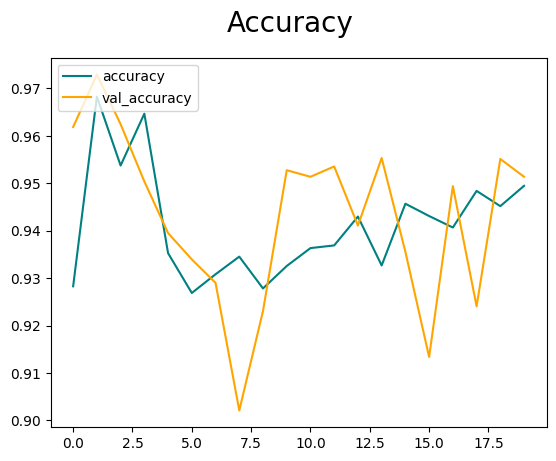

In [13]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [14]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


1/1 [==============================] - 0s 50ms/step
Precision:0.9862825870513916, Recall:0.9603739976882935, Accuracy:0.9529272317886353


# 10. Test

In [12]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

img = cv2.imread('/Users/taehmotheus/Desktop/Deepvoice-detection/test_files/spoof/LA_E_6828287.png')

resize = tf.image.resize(img, (400,1000))

model = load_model('models/imageclassifier.h5')

yhat = model.predict(np.expand_dims(resize/255, 0))

print(yhat)

if yhat > 0.5: 
    print(f'Predicted class is spoof')
else:
    print(f'Predicted class is bonafide')

1/1 [==============================] - 0s 144ms/step
[[1.]]
Predicted class is spoof


# 11. Save the Model

In [19]:
from tensorflow.keras.models import load_model

In [20]:
model.save(os.path.join('models','imageclassifier.h5'))

/Users/taehmotheus/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)